In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
from termcolor import colored
csv.field_size_limit(100000000)
import pickle

from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.float_format = '{:.4f}'.format

# RandomForestClassifier
## TweetsCov19
### (Tweet content + user features)

In [2]:
path = '../data/df_tweetscov19_sample_200000.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'tweet_politic_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted', 'user_vadercompound_average', 'tweet_vadercompound_difference', 'tweet_political_polarisation_difference', 'tweet_science_polarisation_difference', 'tweet_moderacy_polarisation_difference' ])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_difference,tweet_political_polarisation_difference,tweet_science_polarisation_difference,tweet_moderacy_polarisation_difference
0,1239921910114369537,e91f45964db23b2bec20d15fc6c501ae,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,24,0,33.5750,0,0.0000,0.0000,0.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.1250,True,0.0000,0.0000,0.0000,0.0000,0.0000
1,1221651394068992001,7b8c3d61b23ef22900c7e8cac3ef655a,9,21,-0.0320,0.7210,0.2470,0.9431,0,0,268,1,98.7810,0,0.0000,0.0000,0.0000,0.0000,10.1700,0.0000,0.0000,0.0000,5.0800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.7800,0.0000,0.0000,0.0000,0.0000,3.3900,0.0000,0.0000,0.0000,0.0000,0.0000,3.3900,1.6900,0.0000,1.6900,0.0000,6.7800,5.0800,0.0000,0.0000,0.0000,0.0000,5.0800,0.0000,8.4700,10.1700,8.4700,5.0800,5.0800,6.7800,0.0000,10.1700,5.0800,5.0800,0.0000,0.0000,0.0000,0.0000,1.6900,1.6900,1.6900,1.6900,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.3459,True,0.9431,0.0000,0.0000,0.0000,0.0000
2,1247547192606437376,aeed110177e1f18d8e5721dc4257c2aa,12,25,-0.1340,0.5990,0.2680,0.7003,1,0,88,0,53.6550,2,0.4420,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,79,79,1.0000,0.7898,True,0.1608,0.5395,0.0000,0.0000,0.0000
3,1228281231713894401,bf8d92180630f872868ab15fafefa6da,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,105,0,99.4920,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.5300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.5300,15.7900,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.7900,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.0000,True,0.0000,0.0000,0.0000,0.0000,0.0000
4,1239619450455941123,f99928784e541662228f9c85519a0d75,0,0,-0.1620,0.8380,0.0000,-0.6808,0,0,144,0,62.6250,2,0.3330,0.0000,0.0000,0.0000,4.1700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.1700,4.1700,0.0000,0.0000,0.0000,0.0000,4.1700,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,4.1700,0.0000,4.1

In [3]:
df_tweetscov19_user = df_tweetscov19_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape:  (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_difference,tweet_political_polarisation_difference,tweet_science_polarisation_difference,tweet_moderacy_polarisation_difference
0,1182387228640763904,a8d204972eb466750d4ed05501e8e1bd,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,51,0,86.7050,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,20.0000,10.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-1.0000,-0.3333,23,23,1.0000,0.4929,True,-0.0749,0.0000,-1.0000,1.0000,0.3333
1,1250302439195996162,6d5cf96f7628f01d7e07e661c30e4409,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,81,1,57.2340,0,0.0000,0.0000,0.0000,0.0000,15.3800,0.0000,0.0000,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,0.3333,0.0000,0.3333,7,0,0.0000,0.5478,False,0.2936,0.0000,-0.3333,0.0000,-0.3333
2,1226319049224839170,583f511c55d3fc51617cabfb700fe871,13,5,-0.1060,0.8050,0.0890,-0.1090,2,1,164,1,32.4340,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1429,0.0000,-1.0000,68,68,1.0000,0.8611,True,0.0348,-0.1438,0.1429,0.0000,1.0000
3,1245133781637316608,6a7d0a7ab6b4ba9b73c659eb3ea2b8e5,0,0,-0.0000,0.8810,0.1190,0.4019,0,0,157,1,72.6150,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.4100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.4100,3.7000,7.4100,0.0000,3.7000,0.0000,7.4100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.7000,0.0000,-1.0000,0.0000,1.0000,14,0,0.0000,0.9490,False,0.0290,0.3729,1.0000,0.0000,-1.0000
4,1193562834212253696,6461f7d93fc66bf0f37628ad2e56da4f,0,0,-0.0930,0.7320,0.1750,0.4404,1,1,182,0,70.8110,0,0.0000,0.0000,0.0000,0.0000,3.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.3300,6.6700,0.0000,0.0000,10.0000,6.6700,0.0000,0.000

In [4]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg',
       'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num',
       'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent',
       'tweet_politic_polarisation', 'tweet_science_polarisation',
       'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female',
       'male', 'work', 'leisure', 'home', 'money', 'relegion', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body',
       'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad',
       'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear',
       'feel', 'motion', 'space', 'tim

In [5]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 1, 0)
df_tweetscov19_user.tail()

,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_difference,tweet_political_polarisation_difference,tweet_science_polarisation_difference,tweet_moderacy_polarisation_difference
199995,1180997141197668356,a644e38fdba334ed8660693031b99ff6,614,2191,-0.0960,0.7010,0.2020,0.6507,0,0,304,1,27.3410,0,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,7.2700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.6400,0.0000,0.0000,0.0000,1.8200,1.8200,0.0000,1.8200,0.0000,0.0000,0.0000,0.0000,3.6400,0.0000,3.6400,0.0000,3.6400,1.8200,1.8200,0.0000,5.4500,5.4500,0.0000,0.0000,0.0000,0.0000,7.2700,0.0000,9.0900,0.0000,10.9100,7.2700,14.5500,12.7300,0.0000,12.7300,1.8200,1.8200,1.8200,0.0000,0.0000,0.0000,0.0000,1.8200,0.0000,1.8200,3.6400,0.0000,0.0000,0.0000,29,0,0.0000,0.9908,0,0.1496,0.5011,0.0000,0.0000,0.0000
199996,1240628268648271872,de431bfab36530889eb9ff71b9834bf6,0,0,-0.1640,0.6920,0.1450,-0.0772,0,0,86,0,63.4860,0,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.2500,6.2500,6.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,6.2500,0.0000,0.0000,12.5000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,6.2500,6.2500,0.0000,6.2500,0.0000,12.5000,6.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.2500,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.1854,0,-0.0772,0.0000,0.0000,0.0000,0.0000
199997,1265215345821917184,878c0b1d72d1fa22055d57a07337a46e,0,0,-0.0900,0.7670,0.1430,0.1298,0,0,144,0,59.6360,0,0.0000,0.0000,0.0000,0.0000,3.8500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.8500,3.8500,0.0000,0.0000,0.0000,0.0000,3.8500,7.6900,3.8500,3.8500,3.8500,0.0000,0.0000,3.8500,0.0000,0.0000,3.8500,3.8500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.8500,3.8500,11.5400,7.6900,11.5400,3.8500,0.0000,11.5400,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.8500,15.3800,19.2300,0.0000,0.0000,0.0000,4,4,1.0000,0.6996,1,0.1735,-0.0437,0.0000,0.0000,0.0000
199998,1238146787598311424,6a47df1e3e1c7932b4c95a9601eeb1e6,9,7,-0.2600,0.6960,0.0430,-0.8698,0,1,278,0,55.4180,0,0.0000,0.0000,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.4400,4.4400,0.0000,0.0000,0.0000,0.0000,4.4400,0.0000,2.2200,2.2200,2.2200,0.0000,4.4400,0.0000,0.0000,4.4400,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,2.2200,4.4400,8.8900,6.6700,4.4400,2.2200,2.2200,2.2200,11.1100,0.0000,0.0000,2.2200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,23,23,1.0000,0.3952,1,-0.0692,-0.8006,-1.0000,0.0000,-1.0000
199999,1244209004466843649,6092aeb5858d1b17fda0e8049350ecc3,61,47,-0.1310,0.8690,0.0000,-0.6476,7,0,280,1,68.4920,0,0.0000,0.0000,-1.0000,0.0000,7.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,

In [6]:
#df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio'])

In [2]:
def get_X_y(df, features):
    
    if 'Is_deleted' not in features:
        features = np.append(features, 'Is_deleted')
        
    df = df[features.tolist()]
    X = df.drop('Is_deleted', axis=1)
    y = df['Is_deleted']

    y = y.astype(int)
    print(X.shape)
    print(y.shape)
    
    return X,y

In [8]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 89)
(200000,)


In [3]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [10]:
 X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [4]:
def fit_gradientboosting_clf(X,y):
    
    clf = GradientBoostingClassifier()
    clf.fit(X,y)
    return clf

In [5]:
def test_gradientboosting_clf(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [13]:
gb_model = fit_gradientboosting_clf(X_train, y_train)

In [14]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_GB_Benutzer_Inhalt_alle_ohne_moderacy_2.sav'
#pickle.dump(gb_model, open(pfad_modell, 'wb'))

In [15]:
test_gradientboosting_clf(gb_model, X_test, y_test)

Accuracy : 0.6265


In [16]:
y_pred = gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.54      0.59      2015
           1       0.60      0.72      0.66      1985

    accuracy                           0.63      4000
   macro avg       0.63      0.63      0.62      4000
weighted avg       0.63      0.63      0.62      4000



In [6]:
def plot_confusion_matrix(y_test, y_pred, classes, titel):
    
    confusion_mx = confusion_matrix(y_test, y_pred)
    confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
    
    sns.heatmap(confusion_mx, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

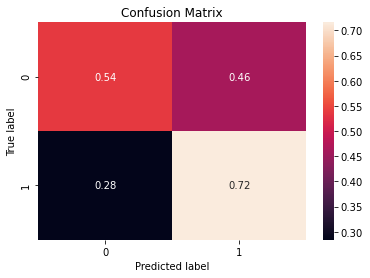

In [18]:
plot_confusion_matrix(y_test, y_pred, gb_model.classes_, 'Confusion Matrix')

In [7]:
def print_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [21]:
clf_cv = GradientBoostingClassifier()
print_cross_val_score(clf_cv, X, y)

 percision : 0.60 +/- 0.009
 f1        : 0.65 +/- 0.010
 recall    : 0.71 +/- 0.014


In [8]:
def features_classifier_(df, model):

    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = model.feature_importances_[i]
        #print(c)
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)

    df_column_feature = df_column_feature.reset_index()
    df_column_feature
    return df_column_feature

In [16]:
clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01, loss='exponential')
clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,83,user_Reputation,0.4586
1,81,user_science_polarisation,0.1614
2,9,URLs_num,0.1398
3,80,user_political_polarisation,0.1021
4,82,user_moderacy_polarisation,0.0474
5,6,Hashtags_num,0.0367
6,8,Text_len,0.0240
7,84,user_vadercompound_average,0.0129
8,88,tweet_moderacy_polarisation_difference,0.0095
9,21,work,0.0046


In [17]:
f_importances = f_importances[f_importances['importance'] != 0]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'user_science_polarisation' 'URLs_num'
 'user_political_polarisation' 'user_moderacy_polarisation' 'Hashtags_num'
 'Text_len' 'user_vadercompound_average'
 'tweet_moderacy_polarisation_difference' 'work'
 'tweet_science_polarisation_difference' 'informal' 'Retweets'
 'tweet_political_polarisation_difference' 'prep' 'Emoji_num']


In [18]:
len(f_importances)

16

In [19]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 16)
(200000,)


In [20]:
clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01 , loss='exponential')
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.58 +/- 0.003
 f1        : 0.66 +/- 0.004
 recall    : 0.76 +/- 0.010


***

***

In [37]:

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

for i in range(len(learning_rate)):

    clf_cv = GradientBoostingClassifier(learning_rate = learning_rate[i] )  
    
    print('learning_rate = ', learning_rate[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

learning_rate =  0.0001
 percision : 0.57 +/- 0.008
 f1        : 0.65 +/- 0.007
 recall    : 0.76 +/- 0.026
---------------------------
learning_rate =  0.001
 percision : 0.57 +/- 0.011
 f1        : 0.65 +/- 0.007
 recall    : 0.76 +/- 0.034
---------------------------
learning_rate =  0.01
 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016
---------------------------
learning_rate =  0.1
 percision : 0.60 +/- 0.010
 f1        : 0.65 +/- 0.012
 recall    : 0.70 +/- 0.018
---------------------------
learning_rate =  0.2
 percision : 0.60 +/- 0.011
 f1        : 0.64 +/- 0.010
 recall    : 0.67 +/- 0.012
---------------------------
learning_rate =  0.3
 percision : 0.60 +/- 0.010
 f1        : 0.63 +/- 0.010
 recall    : 0.65 +/- 0.012
---------------------------


In [38]:
n_estimators = [100, 200, 300, 400, 500, 1000]

for i in range(len(n_estimators)):

    clf_cv = GradientBoostingClassifier(n_estimators = n_estimators[i], learning_rate= 0.01)
    
    print('n_estimators = ', n_estimators[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

n_estimators =  100
 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016
---------------------------
n_estimators =  200
 percision : 0.59 +/- 0.008
 f1        : 0.66 +/- 0.011
 recall    : 0.75 +/- 0.017
---------------------------
n_estimators =  300
 percision : 0.59 +/- 0.009
 f1        : 0.66 +/- 0.011
 recall    : 0.74 +/- 0.016
---------------------------
n_estimators =  400
 percision : 0.59 +/- 0.009
 f1        : 0.66 +/- 0.012
 recall    : 0.73 +/- 0.017
---------------------------
n_estimators =  500
 percision : 0.60 +/- 0.009
 f1        : 0.65 +/- 0.011
 recall    : 0.73 +/- 0.016
---------------------------
n_estimators =  1000
 percision : 0.60 +/- 0.008
 f1        : 0.65 +/- 0.010
 recall    : 0.71 +/- 0.016
---------------------------


***

In [76]:
m_leafnode = [2,4,8,16,32,64]

for i in range(len(m_leafnode)):

    clf_cv = GradientBoostingClassifier(n_estimators = 100,  learning_rate= 0.01, max_leaf_nodes = m_leafnode[i])
    print('max_leaf_nodes = ', m_leafnode[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

max_leaf_nodes =  2
 percision : 0.57 +/- 0.007
 f1        : 0.66 +/- 0.007
 recall    : 0.79 +/- 0.015
---------------------------
max_leaf_nodes =  4
 percision : 0.59 +/- 0.008
 f1        : 0.66 +/- 0.008
 recall    : 0.74 +/- 0.015
---------------------------
max_leaf_nodes =  8
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------
max_leaf_nodes =  16
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------
max_leaf_nodes =  32
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------
max_leaf_nodes =  64
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------
max_leaf_nodes =  128
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.008
 recall    : 0.75 +/- 0.013
---------------------------


In [26]:
max_depth = [2,4,6,8,10]

for i in range(len(max_depth)):

    clf_cv = GradientBoostingClassifier(n_estimators = 100,  learning_rate= 0.01, max_depth = max_depth[i])
    print('max_depth = ', max_depth[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

max_depth =  2
 percision : 0.57 +/- 0.006
 f1        : 0.66 +/- 0.008
 recall    : 0.79 +/- 0.013
---------------------------
max_depth =  4
 percision : 0.58 +/- 0.008
 f1        : 0.66 +/- 0.011
 recall    : 0.76 +/- 0.019
---------------------------
max_depth =  6
 percision : 0.59 +/- 0.007
 f1        : 0.66 +/- 0.010
 recall    : 0.75 +/- 0.019
---------------------------
max_depth =  8
 percision : 0.59 +/- 0.007
 f1        : 0.65 +/- 0.009
 recall    : 0.74 +/- 0.016
---------------------------
max_depth =  10
 percision : 0.59 +/- 0.010
 f1        : 0.65 +/- 0.012
 recall    : 0.73 +/- 0.017
---------------------------


In [27]:
clf_cv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, loss='deviance' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016


In [28]:
clf_cv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, loss='exponential' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.015


In [30]:
clf_cv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, criterion='mse' )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016


In [31]:
clf_cv = GradientBoostingClassifier(n_estimators=100,learning_rate= 0.01,criterion='squared_error')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016


In [32]:
clf_cv = GradientBoostingClassifier(n_estimators=100,learning_rate= 0.01, max_features = 'auto')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.009
 f1        : 0.66 +/- 0.010
 recall    : 0.79 +/- 0.016


In [33]:
clf_cv = GradientBoostingClassifier(n_estimators=100,learning_rate= 0.01, max_features= 'sqrt')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.59 +/- 0.008
 f1        : 0.65 +/- 0.011
 recall    : 0.73 +/- 0.018


In [34]:
clf_cv = GradientBoostingClassifier(n_estimators=100,learning_rate= 0.01, max_features= 'log2')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.59 +/- 0.010
 f1        : 0.64 +/- 0.012
 recall    : 0.71 +/- 0.021


In [15]:
%%time
clf_cv = GradientBoostingClassifier(n_estimators=100, learning_rate= 0.01, loss='exponential')  
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.008
 f1        : 0.66 +/- 0.006
 recall    : 0.78 +/- 0.020
Wall time: 4min 6s


************************************************
************************************************

In [21]:
param_grid = {'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
              'n_estimators' : [100, 200, 300, 400, 500, 1000],
              'max_leaf_nodes' : [2,4,8,16,32],
              'loss' : ['deviance', 'log_loss', 'exponential'],
              'criterion' : ['friedman_mse', 'squared_error', 'mse'],
              'max_features' : ['auto', 'sqrt', 'log2', 'None'],
              'max_depth' : [2,4,6,8,10]}
print(param_grid)

{'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [100, 200, 300, 400, 500, 1000], 'max_leaf_nodes': [2, 4, 8, 16, 32], 'loss': ['deviance', 'log_loss', 'exponential'], 'criterion': ['friedman_mse', 'squared_error', 'mse'], 'max_features': ['auto', 'sqrt', 'log2', 'None'], 'max_depth': [2, 4, 6, 8, 10]}


In [23]:
gb_model = GradientBoostingClassifier()

In [27]:
clf_grid = GridSearchCV(gb_model, param_grid = param_grid, cv = 5, verbose = 10)
#clf_grid.fit(X_train,y_train)

In [ ]:
clf_grid.best_params_

In [ ]:
clf_grid.score(X_test,y_test)

****

In [112]:
%%time
#20000 tweets
#Feature importance != 0.0
#(19 Features)

clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01 , loss='exponential')
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.58 +/- 0.005
 f1        : 0.66 +/- 0.007
 recall    : 0.78 +/- 0.016
Wall time: 4min 4s


In [40]:
%%time
#200000tweets

clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.01, loss='exponential')
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.003
 f1        : 0.66 +/- 0.004
 recall    : 0.76 +/- 0.009
Wall time: 45min 45s


## Plot feature Imortances
### TweetCov19 (Content + User)

In [25]:
def plot_hist_Features(l_features_importances, l_features, titel):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue', 'indigo', 'brown', 'green', 'black']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Gradient Boosting', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
         
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout() #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [26]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Political p.u.', 'Retweets', 'Likes', 'Reputation', 'Science p.u.']

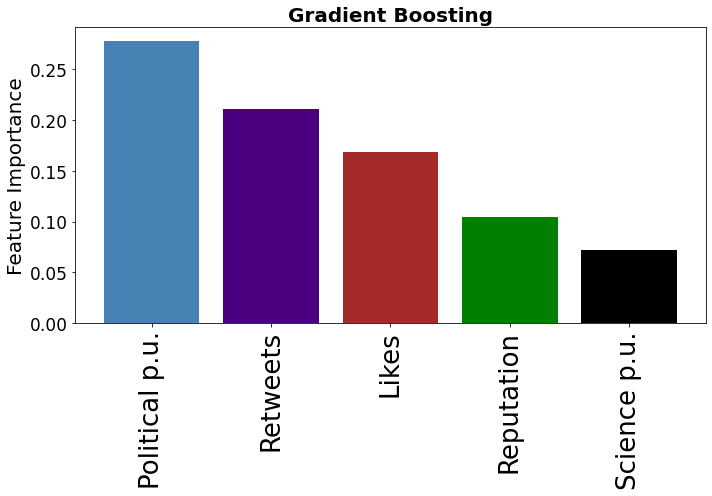

In [27]:
plot_hist_Features(l_features_importances, l_features, 'Gb_TweetsCov19_content_User(reputation)_2_o_moderacy_all_del')

************************************************
************************************************

## TweetsCov19
### (Content only)

In [22]:
features = df_tweetscov19_user.columns
features

#features = features[2:83]
df_tweetscov19_user = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_vadercompound_average', 'tweet_vadercompound_difference', 'tweet_political_polarisation_difference', 'tweet_science_polarisation_difference', 'tweet_moderacy_polarisation_difference'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [24]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(20000, 80)
(20000,)


In [25]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 80)
(4000, 80)
(16000,)
(4000,)


In [26]:
%%time
gb_model = fit_gradientboosting_clf(X_train, y_train)
test_gradientboosting_clf(gb_model, X_test, y_test)

Accuracy : 0.59375
Wall time: 6.11 s


In [27]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_GB_Inhalt_all_ohne_moderacy.sav'
#pickle.dump(gb_model, open(pfad_modell, 'wb'))

In [29]:
f_importances = features_classifier_(X, gb_model)
f_importances

,index,Feature,importance
0,9,URLs_num,0.1057
1,0,Retweets,0.0707
2,8,Text_len,0.0562
3,1,Favorites,0.0538
4,14,tweet_science_polarisation,0.0509
5,10,readability,0.0465
6,6,Hashtags_num,0.0427
7,13,tweet_politic_polarisation,0.0338
8,68,verb,0.0333
9,63,prep,0.0298


In [30]:
y_pred = gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58      2002
           1       0.59      0.62      0.60      1998

    accuracy                           0.59      4000
   macro avg       0.59      0.59      0.59      4000
weighted avg       0.59      0.59      0.59      4000



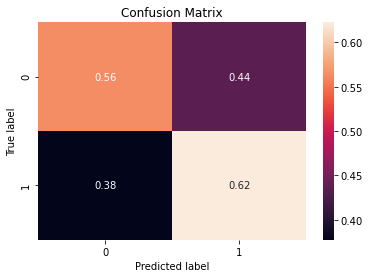

In [31]:
plot_confusion_matrix(y_test, y_pred, gb_model.classes_, 'Confusion Matrix')

In [32]:
%%time
clf_cv = GradientBoostingClassifier(n_estimators=100,  learning_rate = 0.1 )  
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.008
 f1        : 0.61 +/- 0.008
 recall    : 0.63 +/- 0.008
Wall time: 3min 27s


********************************************************
********************************************************

## Plot feature Imortances
### TweetsCov19 (Content Only)

In [37]:
def plot_hist_Features_content_only(l_features_importances, l_features, titel):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['brown', 'peru', 'black','tan', 'mediumslateblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Gradient Boosting', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
         
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    
    fig.tight_layout()  
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [38]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Retweets', 'Likes', 'Science p.T.', 'Political p.T.', 'Text l.']

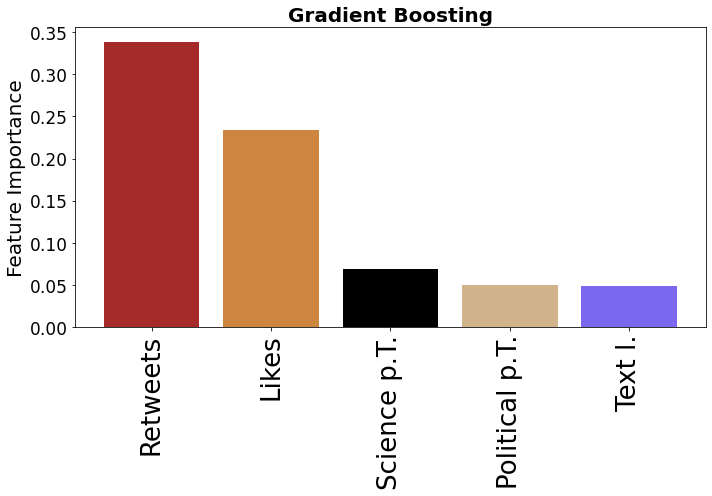

In [39]:
plot_hist_Features_content_only(l_features_importances, l_features, 'Gb_TweetsCov19_content_only_o_moderacy_all_del')

************************************************
************************************************

# Tweetskb
### (Content + User Features)

In [9]:
path = '../data/df_tweetskb_sample_200000.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'tweet_politic_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted', 'user_vadercompound_average', 'tweet_vadercompound_difference', 'tweet_political_polarisation_difference', 'tweet_science_polarisation_difference', 'tweet_moderacy_polarisation_difference'])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_difference,tweet_political_polarisation_difference,tweet_science_polarisation_difference,tweet_moderacy_polarisation_difference
0,1183735622982344705,ScandalofSpeed,2,10,-0.0790,0.8860,0.0350,-0.3382,0,0,187,0,60.1090,0,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,3.4500,0.0000,3.4500,6.9000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,10.3400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,3.4500,6.9000,10.3400,3.4500,3.4500,6.9000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.8471,True,-0.3382,0.0000,0.0000,0.0000,0.0000
1,1219313839151423495,pwns4cash,0,0,-0.0000,0.7060,0.2940,0.3612,0,1,41,0,78.8730,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.6873,True,0.3612,0.0000,0.0000,0.0000,0.0000
2,1188314245760311296,MadMax26125746,0,0,-0.2680,0.7320,0.0000,-0.5106,0,1,63,0,52.8650,0,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18.1800,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,9.0900,0.0000,18.1800,0.0000,0.0000,0.0000,18.1800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.7047,True,-0.5106,0.0000,0.0000,0.0000,0.0000
3,1199082882238537729,kirstenigot,0,0,-0.0000,0.7410,0.2590,0.6739,2,0,105,1,53.6390,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.2500,True,0.4918,0.1821,0.0000,0.0000,0.0000
4,1209565509068500992,pie_yann,0,0,-0.6940,0.3060,0.0000,-0.7783,0,2,34,0,66.4000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,40.0000,40.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.

In [10]:
features = df_tweetskb_user.columns
#features

In [11]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 1, 0)
df_tweetskb_user.tail()

,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_difference,tweet_political_polarisation_difference,tweet_science_polarisation_difference,tweet_moderacy_polarisation_difference
199995,1199740653963489285,brinabobina15,0,0,-0.0000,0.3610,0.6390,0.6486,0,1,22,0,75.8750,1,0.0000,0.0000,0.0000,0.0000,33.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,33.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.5307,0,0.5796,0.0690,0.0000,0.0000,0.0000
199996,1226682818048118784,eunhyedoo,4,18,-0.0990,0.9010,0.0000,-0.3182,0,0,117,0,65.2960,0,0.0000,0.0000,0.0000,0.0000,18.1800,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,4.5500,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,4.5500,4.5500,9.0900,9.0900,4.5500,9.0900,4.5500,22.7300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,13,0,0.0000,0.4211,0,-0.0021,-0.3161,0.0000,0.0000,0.0000
199997,1263852788280430593,Harleysdad65,35,139,-0.1350,0.5810,0.2840,0.8934,0,0,120,0,100.0150,5,0.2157,0.0000,0.0000,0.0000,14.2900,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,4.7600,0.0000,4.7600,0.0000,0.0000,9.5200,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,4.7600,14.2900,14.2900,4.7600,0.0000,9.5200,14.2900,4.7600,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,14.2900,0.0000,0.0000,0.0000,0.0000,24,0,0.0000,0.6314,0,0.3977,0.4957,0.0000,0.0000,0.0000
199998,1230926459776061440,USLTER,1,1,-0.0000,0.8300,0.1700,0.7993,4,2,285,1,52.2450,0,0.0000,0.0000,0.0000,0.0000,4.6500,0.0000,0.0000,0.0000,0.0000,6.9800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,2.3300,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.6500,0.0000,0.0000,0.0000,4.6500,0.0000,0.0000,2.3300,2.3300,13.9500,4.6500,0.0000,0.0000,0.0000,6.9800,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.6500,2.3300,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.8019,0,0.7993,0.0000,0.0000,0.0000,0.0000
199999,1215871785591353345,kpoplover727,102,239,-0.0000,0.7200,0.2800,0.9648,0,0,264,0,37.6580,1,0.0000,0.0000,0.0000,0.0000,5.7700,0.0000,0.0000,0.0000,0.0000,3.8500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.8500,1.9200,0.0000,1.9200,1.9200,0.0000,0.0000,0.0000,1.9200,13.4600,1.9200

In [12]:
df_tweetskb_user = df_tweetskb_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape:  (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_difference,tweet_political_polarisation_difference,tweet_science_polarisation_difference,tweet_moderacy_polarisation_difference
0,1228784674497007623,pyrrhophytes,5,6,-0.1670,0.8330,0.0000,-0.7003,10,0,309,1,-11.3520,0,0.0000,0.0000,0.0000,0.0000,4.6500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,0.0000,0.0000,2.3300,4.6500,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.6500,2.3300,0.0000,9.3000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,0.0000,0.0000,6.9800,6.9800,0.0000,0.0000,0.0000,9.3000,4.6500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.6500,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.4762,1,-0.3502,-0.3502,0.0000,0.0000,0.0000
1,1233555870996287488,duyvan64,0,0,-0.0830,0.6340,0.2820,0.9323,0,2,294,1,65.6960,0,0.0000,0.0000,0.0000,0.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,6.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.0000,4.0000,4.0000,0.0000,2.0000,2.0000,2.0000,8.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,10.0000,6.0000,6.0000,4.0000,2.0000,2.0000,8.0000,6.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4,4,1.0000,0.1705,1,0.6338,0.2985,0.0000,0.0000,0.0000
2,1255341832558559232,nataaa_x,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,74,0,71.7680,0,0.0000,0.0000,0.0000,0.0000,15.3800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,7.6900,7.6900,7.6900,0.0000,0.0000,7.6900,0.0000,15.3800,0.0000,0.0000,7.6900,0.0000,0.0000,0.0000,15.3800,7.6900,7.6900,15.3800,7.6900,0.0000,7.6900,23.0800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.5390,0,0.0000,0.0000,0.0000,0.0000,0.0000
3,1228382179710918657,LE_DeLano,1,0,-0.0000,0.6860,0.3140,0.7506,2,0,125,0,26.6830,0,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,10.5300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.5300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.7900,5.2600,0.0000,0.0000,0.0000,5.2600,5.2600,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.4244,0,0.7506,0.0000,0.0000,0.0000,0.0000
4,1210926344114262017,Jenna_Blue4,10,14,-0.0000,0.5540,0.4460,0.9771,0,0,186,0,92.6450,6,0.5403,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,0.

In [13]:
print(len(features))
features

95


Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg',
       'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num',
       'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent',
       'tweet_politic_polarisation', 'tweet_science_polarisation',
       'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female',
       'male', 'work', 'leisure', 'home', 'money', 'relegion', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body',
       'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad',
       'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear',
       'feel', 'motion', 'space', 'tim

In [14]:
#df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio'])

In [15]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 89)
(200000,)


In [16]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [18]:
gb_model = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
gb_model.fit(X_train, y_train)

f_importances = features_classifier_(X, gb_model)
f_importances

,index,Feature,importance
0,83,user_Reputation,0.2107
1,80,user_political_polarisation,0.0917
2,55,focusfuture,0.0881
3,81,user_science_polarisation,0.0829
4,9,URLs_num,0.0826
5,27,informal,0.0790
6,62,article,0.0785
7,21,work,0.0651
8,6,Hashtags_num,0.0404
9,7,Mentions_num,0.0385


In [19]:
%%time
#200 000 tweets

clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
print_cross_val_score(clf_cv, X, y)

 percision : 0.56 +/- 0.003
 f1        : 0.59 +/- 0.005
 recall    : 0.63 +/- 0.012
Wall time: 1h 14min 7s


*****************************************************
*****************************************************

## Plot feature Imortances
### Tweetkb (Content + User)

In [56]:
def plot_hist_Features_kb(l_features_importances, l_features, titel):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue', 'brown', 'green', 'Indigo', 'lightblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Gradient Boosting', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

   
    fig.tight_layout()
    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [57]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Likes', 'Political p.u.', 'Reputation', 'Retweets', 'Science p.u.']

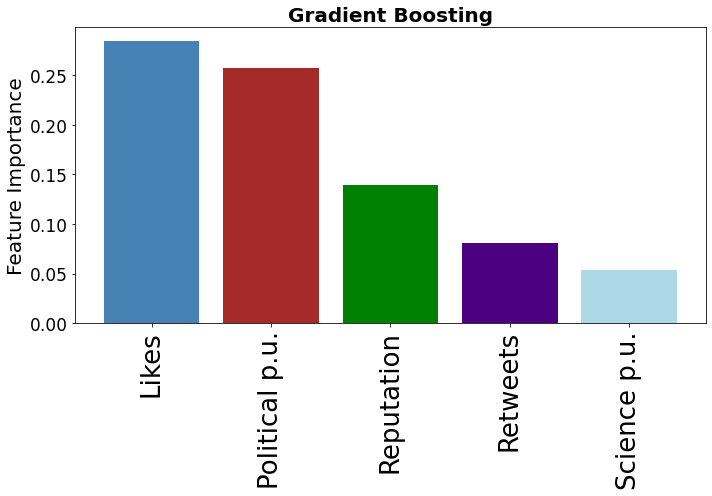

In [58]:
plot_hist_Features_kb(l_features_importances, l_features, 'Gb_Tweetskb_content_User(reputation)_2_o_moderacy_all_del')

***********************************************************************
***********************************************************************

## Tweetskb
### Content only


In [20]:
features = df_tweetskb_user.columns
features

#features = features[2:83]
df_tweetskb_user = df_tweetskb_user[features.tolist()]
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_vadercompound_average', 'tweet_vadercompound_difference', 'tweet_political_polarisation_difference', 'tweet_science_polarisation_difference', 'tweet_moderacy_polarisation_difference'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [21]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 80)
(200000,)


In [22]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [25]:
gb_model = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
gb_model.fit(X_train, y_train)

f_importances = features_classifier_(X, gb_model)
f_importances

,index,Feature,importance
0,9,URLs_num,0.1408
1,55,focusfuture,0.1273
2,27,informal,0.1173
3,62,article,0.1132
4,21,work,0.1059
5,6,Hashtags_num,0.0607
6,35,sexual,0.0581
7,8,Text_len,0.0556
8,7,Mentions_num,0.0465
9,13,tweet_politic_polarisation,0.0296


In [26]:
%%time
#200 000 tweets

clf_cv = GradientBoostingClassifier(n_estimators=200,learning_rate= 0.01, max_leaf_nodes=8)  
print_cross_val_score(clf_cv, X, y)

 percision : 0.55 +/- 0.003
 f1        : 0.58 +/- 0.004
 recall    : 0.62 +/- 0.007
Wall time: 1h 4min 30s


***************************************************
***************************************************

## Plot feature Imortances
### Tweetskb (Content Only)

In [70]:
def plot_hist_Features_content_only_kb(l_features_importances, l_features, titel):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['brown','khaki', 'lightsalmon', 'lightskyblue', 'maroon']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Gradient Boosting', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
    
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=13)

    #fig.tight_layout()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [71]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Likes', 'Political p.T.', 'Retweets', 'Science p.T.', 'Readability']

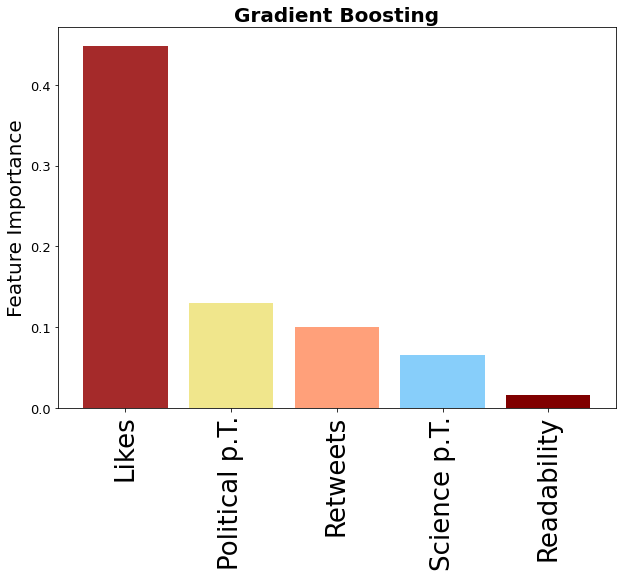

In [72]:
plot_hist_Features_content_only_kb(l_features_importances, l_features, 'Gb_Tweetskb_content_only_o_moderacy_all_del')